In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
from helpers import Reconstruct, Viz_Y,SMR,get_mixed_signal,SDR
import seaborn as sns
import warnings
import torch
import math
from tqdm import tqdm
import librosa
warnings.simplefilter('ignore')

In [2]:
N_minutes = 2*60*44100
samplerate_s, data_speech = read("../../DATA/vocal_11.wav")
speech=data_speech[44100*10:N_minutes,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {}'.format(speech.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_s))

samplerate_m, data_music = read("../../DATA/piano_10.wav")
music=data_music[44100*10:N_minutes,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_m))



Shape of the speech 4851000
Length : 110.00s
Sample rate : 44100
Shape of the music 4851000
Length : 110.00s
Sample rate : 44100


In [8]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=1024


SMR_db = 1
samplerate = samplerate_m

In [9]:
# Set the test data:
test,speech_test,music_test=get_mixed_signal(speech,music,SMR_db)
test=test[5*882000:6*882000]
speech_test=speech_test[5*882000:6*882000]
music_test = music_test[5*882000:6*882000]


f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_s=np.abs(Y)

f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_m=np.abs(Y)

f,t,Y= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_t=np.abs(Y)

Yabs_s[Yabs_s==0]=0.001
Yabs_t[Yabs_t==0]=0.001
Yabs_m[Yabs_m==0]=0.001



SMR = 1.00


# Training stage :

In [52]:
Ns = 2
Nm = 2
max_iter=100

In [53]:
model = NMF(n_components=Ns, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=max_iter, random_state=0)
G_s = model.fit_transform(np.transpose(Yabs_s))
B_s = model.components_

print('Training Stage ... Speech NMF  ... Done!')

model = NMF(n_components=Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=max_iter, random_state=0)
G_m = model.fit_transform(np.transpose(Yabs_m))
B_m = model.components_

print('Training Stage ... Music NMF ... Done!')

B=np.vstack([B_s,B_m])


Training Stage ... Speech NMF  ... Done!
Training Stage ... Music NMF ... Done!


# Testing stage : 

In [54]:
model_test = NMF(n_components=Ns+Nm, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=max_iter, random_state=0)
model_test.fit(np.transpose(Yabs_t))
B0 = model_test.components_

In [55]:
model_test.components_=B
G_test=model_test.transform(np.transpose(Yabs_t))
B1=model_test.components_

# Verify that the B did not change after the transform:

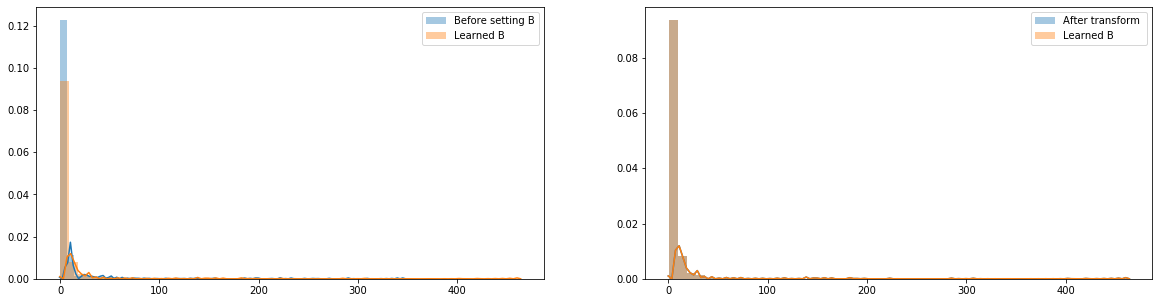

In [56]:
fig,ax=plt.subplots(1,2,figsize=(20,5))

sns.distplot(B0,ax=ax[0])
sns.distplot(B,ax=ax[0])
ax[0].legend(['Before setting B','Learned B'])

sns.distplot(B1,ax=ax[1])
sns.distplot(B,ax=ax[1])
ax[1].legend(['After transform ','Learned B'])



In [57]:
if (B1==B).all() :
    
    print('The learned B is kept after transform')
    
else :
    
    print('B changed after doing the transform!')

The learned B is kept after transform


In [62]:
print('Mean of B = {}'.format(B.mean()))

Mean of B = 5.6739230124893165


In [29]:
print(Yabs_s.shape)
print(B0.shape)

(257, 54)
(257, 8)


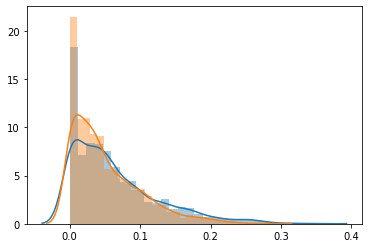

In [30]:
sns.distplot(B0)
sns.distplot(G1)

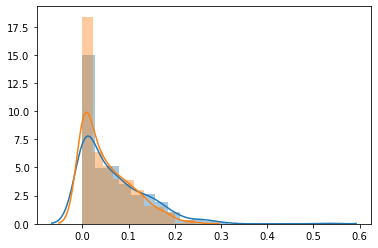

In [31]:
sns.distplot(B1)
sns.distplot(G0)

**We conclude that the fit_transform gives the B which has  a shape of 257*r**

# Check if the NMF freezes the B when doing a decomposition on test set:

In [50]:
n_components=2
model = NMF(n_components=n_components, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=10000, random_state=0)
B0 = model.fit_transform(np.transpose(Yabs_s))
G0 = model.components_

In [51]:
B1=model.transform(np.transpose(Yabs_test))
G1=model.components_

In [49]:
print(G0.shape)

(2, 257)


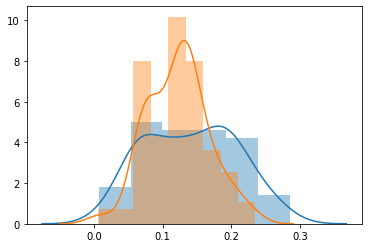

In [52]:
sns.distplot(B0)
sns.distplot(B1)

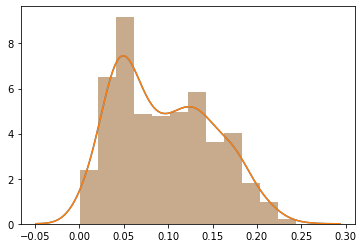

In [53]:
sns.distplot(G1)
sns.distplot(G0)

**In conclusion we must fit adn predict on the transposed spectrograms and inverse between B and G**